In [0]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from dateutil.relativedelta import relativedelta

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.initializers import glorot_uniform

plt.rcParams['figure.facecolor'] = 'w'


In [0]:
import os
os.environ['PYTHONHASHSEED']=str(42)

import random
random.seed(42)

In [0]:
tf.random.set_seed(42)

In [0]:
np.random.seed(42)

In [0]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount = False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
save_path = ''

# Load Data

In [0]:
url = 'https://pomber.github.io/covid19/timeseries.json'

In [0]:
response = requests.get(url)

In [0]:
json = response.json()

# EDA

In [0]:
pd.DataFrame(json).head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Diamond Princess,...,Tanzania,Thailand,Togo,Trinidad and Tobago,Tunisia,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Kosovo,Burma,MS Zaandam,Botswana,Burundi,Sierra Leone,Malawi,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
0,"{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 548, 'death...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...",...,"{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 2, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 1, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'.

In [0]:
countries = json.keys()
df_array = []

Convert dataframe to long-format

In [0]:
for country in countries:
  stats = json[country]
  for stat in stats:
    # build row
    date = stat['date']
    confirmed = stat['confirmed']
    deaths = stat['deaths']
    recovered = stat['recovered']
    df_array.append([country, date, confirmed, deaths, recovered])

In [0]:
df = pd.DataFrame(df_array)

In [0]:
df.columns = ['country', 'date', 'confirmed', 'deaths', 'recovered'] ; df.head()

,country,date,confirmed,deaths,recovered
0,Afghanistan,2020-1-22,0,0,0
1,Afghanistan,2020-1-23,0,0,0
2,Afghanistan,2020-1-24,0,0,0
3,Afghanistan,2020-1-25,0,0,0
4,Afghanistan,2020-1-26,0,0,0


In [0]:
# Convert to datetime object
df['date'] = pd.to_datetime(df['date'])

In [0]:
# Get last date
df['date'].max()

Timestamp('2020-04-16 00:00:00')

# Description Statistics

In [0]:
last_date_df = df[df['date'] == df['date'].max()]

In [0]:
total_confirmed = last_date_df['confirmed'].sum()
total_deaths = last_date_df['deaths'].sum()
total_recovered = last_date_df['recovered'].sum()
print(total_confirmed, total_deaths, total_recovered)

2152646 143800 542107


In [0]:
def get_totals(df: pd.DataFrame) -> list:
  df = df[df['date'] == df['date'].max()]
  return [df['confirmed'].sum(), df['deaths'].sum(), df['recovered'].sum()]

# Country Infection History

In [0]:
# Look at one country
country = 'Canada'
country_df = df[df['country'] == country]
country_df.head(10)

,country,date,confirmed,deaths,recovered
2408,Canada,2020-01-22,0,0,0
2409,Canada,2020-01-23,0,0,0
2410,Canada,2020-01-24,0,0,0
2411,Canada,2020-01-25,0,0,0
2412,Canada,2020-01-26,1,0,0
2413,Canada,2020-01-27,1,0,0
2414,Canada,2020-01-28,2,0,0
2415,Canada,2020-01-29,2,0,0
2416,Canada,2020-01-30,2,0,0
2417,Canada,2020-01-31,4,0,0


In [0]:
print(get_totals(country_df))

[30808, 1257, 9698]


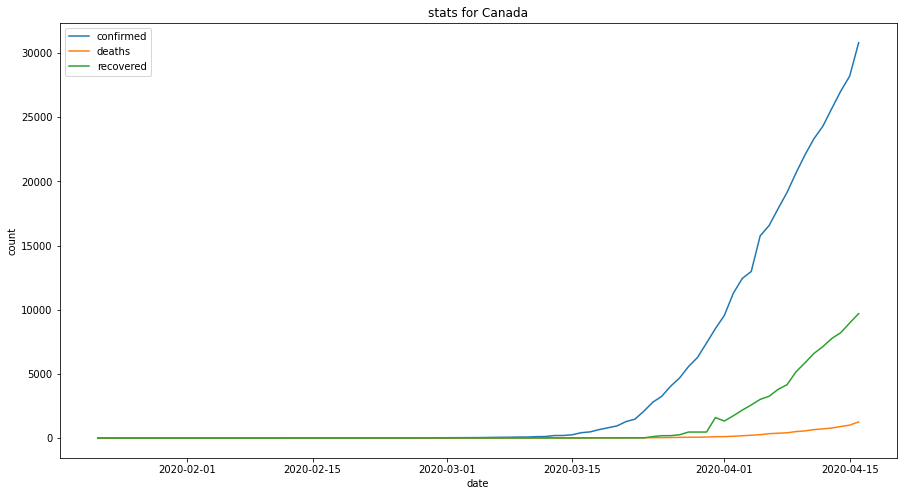

In [0]:
plt.figure(figsize=(15,8))

plt.plot(country_df['date'], country_df['confirmed'], label='confirmed')
plt.plot(country_df['date'],country_df['deaths'], label= 'deaths')
plt.plot(country_df['date'],country_df['recovered'], label = 'recovered')

plt.title(f'stats for {country}')
plt.ylabel('count')
plt.xlabel('date')
plt.legend()

Because of limited data we turn this problem into classification by framing it like a weather forecasting problem as follows:

"Based on data from the past 7 days, what is the number of confirmed cases on the 8th day?"

We frame this similarly for the mortality prediction as well.


# Focus on Canada

In [0]:
country = 'Canada'
canada_df = df[df['country'] == country].copy()
canada_df.reset_index(drop=True,inplace=True)

In [0]:
canada_df.head(10)

,country,date,confirmed,deaths,recovered
0,Canada,2020-01-22,0,0,0
1,Canada,2020-01-23,0,0,0
2,Canada,2020-01-24,0,0,0
3,Canada,2020-01-25,0,0,0
4,Canada,2020-01-26,1,0,0
5,Canada,2020-01-27,1,0,0
6,Canada,2020-01-28,2,0,0
7,Canada,2020-01-29,2,0,0
8,Canada,2020-01-30,2,0,0
9,Canada,2020-01-31,4,0,0


## Some feature engineering

In [0]:
new_confirmed = canada_df['confirmed'].diff()
new_deaths = canada_df['deaths'].diff()

In [0]:
canada_df['new_confirmed'] = new_confirmed
canada_df['new_deaths'] = new_deaths

In [0]:
canada_df.head(10)

,country,date,confirmed,deaths,recovered,new_confirmed,new_deaths
0,Canada,2020-01-22,0,0,0,NaN,NaN
1,Canada,2020-01-23,0,0,0,0.0,0.0
2,Canada,2020-01-24,0,0,0,0.0,0.0
3,Canada,2020-01-25,0,0,0,0.0,0.0
4,Canada,2020-01-26,1,0,0,1.0,0.0
5,Canada,2020-01-27,1,0,0,0.0,0.0
6,Canada,2020-01-28,2,0,0,1.0,0.0
7,Canada,2020-01-29,2,0,0,0.0,0.0
8,Canada,2020-01-30,2,0,0,0.0,0.0
9,Canada,2020-01-31,4,0,0,2.0,0.0


In [0]:
canada_df.tail()

,country,date,confirmed,deaths,recovered,new_confirmed,new_deaths
81,Canada,2020-04-12,24298,714,7123,982.0,60.0
82,Canada,2020-04-13,25679,779,7758,1381.0,65.0
83,Canada,2020-04-14,27034,899,8210,1355.0,120.0
84,Canada,2020-04-15,28208,1006,8966,1174.0,107.0
85,Canada,2020-04-16,30808,1257,9698,2600.0,251.0


In [0]:
canada_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   country        86 non-null     object        
 1   date           86 non-null     datetime64[ns]
 2   confirmed      86 non-null     int64         
 3   deaths         86 non-null     int64         
 4   recovered      86 non-null     int64         
 5   new_confirmed  85 non-null     float64       
 6   new_deaths     85 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 4.8+ KB


In [0]:
canada_df.set_index('date', inplace=True)

In [0]:
canada_df.head(10)

,country,confirmed,deaths,recovered,new_confirmed,new_deaths
date,,,,,,
2020-01-22,Canada,0,0,0,NaN,NaN
2020-01-23,Canada,0,0,0,0.0,0.0
2020-01-24,Canada,0,0,0,0.0,0.0
2020-01-25,Canada,0,0,0,0.0,0.0
2020-01-26,Canada,1,0,0,1.0,0.0
2020-01-27,Canada,1,0,0,0.0,0.0
2020-01-28,Canada,2,0,0,1.0,0.0
2020-01-29,Canada,2,0,0,0.0,0.0
2020-01-30,Canada,2,0,0,0.0,0.0


In [0]:
"""
#forecast_date = '2020-04-10'
#train = canada_df.loc[:forecast_date]
train = canada_df.copy()

n_forecast_window = 7
test = canada_df.iloc[-(n_forecast_window*2):]

forecast_date = test.index.tolist()[0].strftime('%Y-%m-%d')
print(forecast_date)
"""

"\n#forecast_date = '2020-04-10'\n#train = canada_df.loc[:forecast_date]\ntrain = canada_df.copy()\n\nn_forecast_window = 7\ntest = canada_df.iloc[-(n_forecast_window*2):]\n\nforecast_date = test.index.tolist()[0].strftime('%Y-%m-%d')\nprint(forecast_date)\n"

# Data Split

Take data before `2020-04-01` as training while data after as test

In [0]:
#train.reset_index(drop=True, inplace=True)

Want to rearrange the data set to be of the form
```
    | var(t-n) | var(t-(n-1)) | ... | var(t-1) | var(t) |
    ---------------------------------------------------- 
  0 |
  1 |
```
where the far right column is the output forecasting variable (i.e., y) and the columns on its left are the input variables.

In [0]:
"""
PROTOTYPE

temp = canada_df.copy()
target = 'confirmed'
x=[]
y=[]
n_steps = 7
sequence=list(temp[target])
for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    if(seq_y!=0):
        x.append(seq_x)   
        y.append(seq_y)
"""

"\nPROTOTYPE\n\ntemp = canada_df.copy()\ntarget = 'confirmed'\nx=[]\ny=[]\nn_steps = 7\nsequence=list(temp[target])\nfor i in range(len(sequence)):\n    end_ix = i + n_steps\n    if end_ix > len(sequence)-1:\n        break\n    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]\n    if(seq_y!=0):\n        x.append(seq_x)   \n        y.append(seq_y)\n"

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.

  SOURCE: ML Mastery time series tutorial
	"""
  # Determine the number of input variables
  n_vars = 1 if type(data) is list else data.shape[0]
  df = pd.DataFrame(data)
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
	# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [0]:
"""
confirmed = canada_df['confirmed'].tolist()
agg = series_to_supervised(confirmed, n_forecast_window)

train_val_c = train['confirmed'].tolist()
test_c = test['confirmed'].tolist()

train_val_d = train['deaths'].tolist()
test_d = test['deaths'].tolist()
"""

"\nconfirmed = canada_df['confirmed'].tolist()\nagg = series_to_supervised(confirmed, n_forecast_window)\n\ntrain_val_c = train['confirmed'].tolist()\ntest_c = test['confirmed'].tolist()\n\ntrain_val_d = train['deaths'].tolist()\ntest_d = test['deaths'].tolist()\n"

## Further split train for validation

In [0]:
"""
train_val_c_agg = series_to_supervised(train_val_c, n_forecast_window)
test_c_agg = series_to_supervised(test_c, n_forecast_window)

X_tv_c = train_val_c_agg.drop(columns=['var1(t)']).to_numpy()
y_tv_c = train_val_c_agg['var1(t)'].to_numpy()

X_test_c = test_c_agg.drop(columns=['var1(t)']).to_numpy()
y_test_c = test_c_agg['var1(t)'].to_numpy()
"""

"\ntrain_val_c_agg = series_to_supervised(train_val_c, n_forecast_window)\ntest_c_agg = series_to_supervised(test_c, n_forecast_window)\n\nX_tv_c = train_val_c_agg.drop(columns=['var1(t)']).to_numpy()\ny_tv_c = train_val_c_agg['var1(t)'].to_numpy()\n\nX_test_c = test_c_agg.drop(columns=['var1(t)']).to_numpy()\ny_test_c = test_c_agg['var1(t)'].to_numpy()\n"

## Reshape for LSTM

Must be in the form:

```[samples, timesteps, features]```

In [0]:
"""
X_tv_c = X_tv_c.reshape((X_tv_c.shape[0], 1, X_tv_c.shape[1]))
X_test_c = X_test_c.reshape((X_test_c.shape[0], 1, X_test_c.shape[1]))

X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_tv_c, y_tv_c, test_size=0.2, random_state=42)
"""

'\nX_tv_c = X_tv_c.reshape((X_tv_c.shape[0], 1, X_tv_c.shape[1]))\nX_test_c = X_test_c.reshape((X_test_c.shape[0], 1, X_test_c.shape[1]))\n\nX_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_tv_c, y_tv_c, test_size=0.2, random_state=42)\n'

# Model Preparation

In [0]:
"""
# Initializing model components
epochs = 30
batch_size = 16
n_hidden = 32
timesteps = X_train_c.shape[1]
input_dim = X_train_c.shape[2]
n_features=1
n_steps=n_forecast_window
print(timesteps)
print(input_dim)
print(len(X_train_c))


# define model

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_features, n_steps), return_sequences=True, kernel_initializer=glorot_uniform(seed=42)))
model.add(LSTM(128, activation='relu', kernel_initializer=glorot_uniform(seed=42)))
model.add(Dense(1, activation='relu', kernel_initializer=glorot_uniform(seed=42)))
model.summary()
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())


# fit model
model.fit(X_train_c, y_train_c, epochs=epochs, validation_data=(X_val_c, y_val_c), verbose=2)
"""

"\n# Initializing model components\nepochs = 30\nbatch_size = 16\nn_hidden = 32\ntimesteps = X_train_c.shape[1]\ninput_dim = X_train_c.shape[2]\nn_features=1\nn_steps=n_forecast_window\nprint(timesteps)\nprint(input_dim)\nprint(len(X_train_c))\n\n\n# define model\n\nmodel = Sequential()\nmodel.add(LSTM(100, activation='relu', input_shape=(n_features, n_steps), return_sequences=True, kernel_initializer=glorot_uniform(seed=42)))\nmodel.add(LSTM(128, activation='relu', kernel_initializer=glorot_uniform(seed=42)))\nmodel.add(Dense(1, activation='relu', kernel_initializer=glorot_uniform(seed=42)))\nmodel.summary()\nmodel.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())\n\n\n# fit model\nmodel.fit(X_train_c, y_train_c, epochs=epochs, validation_data=(X_val_c, y_val_c), verbose=2)\n"

# Forecasting

In [0]:
def forecast(model,data,start_date,n_days, n_steps):
  """
	Produce a forecast prediction.
	Arguments:
		model: Trained model for the forecasting
		start_date: starting date for the forecast
		n_days: Number of days to forecast after start_date.
		n_steps: The forecast window
	Returns:
		Pandas DataFrame of series framed with forecasting results.

  SOURCE: ML Mastery time series tutorial
	"""
  res=dict()
  
  for i in range(len(data)):
      res[i]=[]
  y_pred=model.predict(data)
  dates=[]
  data_window = data.copy()  # Make a copy
  date1 = pd.datetime.datetime.strptime(start_date, "%Y-%m-%d")
  for j in range(1,n_days+1):
      for i in range(len(data_window)):
          cur_window=list(data_window[i][0][1:n_steps+1])
          print(j,i,cur_window[-1])
          res[i].append(cur_window[-1])
          cur_window.append(y_pred[i])
          data_window[i][0]=cur_window
      y_pred=model.predict(data_window)
      print(y_pred)
      dates.append(date1.strftime("%Y-%m-%d"))
      date1+=relativedelta(days=1)
  res=pd.DataFrame(pd.DataFrame(pd.DataFrame(res).values.T))
  #res=pd.DataFrame(res).T
  #print(res)
  res.columns=dates
  #res['Country/State']=regs
  return res

In [0]:
#forecast_date = '2020-04-15'
#test = canada_df.loc[forecast_date:]

In [0]:
"""
model.predict(X_test_c)

n_forecast_days=10
r = forecast(model, X_test_c, forecast_date, n_forecast_days, n_forecast_window)


dates=[]
date1 = forecast_date
dates.append(date1)
for i in range(n_days+1):
  date1 = pd.datetime.datetime.strptime(date1, "%Y-%m-%d")
  date1+=relativedelta(days=1)
  date1 = date1.strftime("%Y-%m-%d")
  dates.append(date1)



r.set_index(dates, inplace=True)

#plt.figure(figsize=(15,8))
#ax = plt.figure(figsize=(15,6))
ax = canada_df.plot(y='confirmed', label='confirmed', figsize=(15,5))
r.iloc[:,0].plot( label='forecast', ax=ax)

#plt.title(f'stats for {country}')
plt.ylabel('count')
plt.xlabel('date')
plt.legend()


model.save(save_path + 'lstm.h5')
"""

'\nmodel.predict(X_test_c)\n\nn_forecast_days=10\nr = forecast(model, X_test_c, forecast_date, n_forecast_days, n_forecast_window)\n\n\ndates=[]\ndate1 = forecast_date\ndates.append(date1)\nfor i in range(n_days+1):\n  date1 = pd.datetime.datetime.strptime(date1, "%Y-%m-%d")\n  date1+=relativedelta(days=1)\n  date1 = date1.strftime("%Y-%m-%d")\n  dates.append(date1)\n\n\n\nr.set_index(dates, inplace=True)\n\n#plt.figure(figsize=(15,8))\n#ax = plt.figure(figsize=(15,6))\nax = canada_df.plot(y=\'confirmed\', label=\'confirmed\', figsize=(15,5))\nr.iloc[:,0].plot( label=\'forecast\', ax=ax)\n\n#plt.title(f\'stats for {country}\')\nplt.ylabel(\'count\')\nplt.xlabel(\'date\')\nplt.legend()\n\n\nmodel.save(save_path + \'lstm.h5\')\n'

# Data Processing - All countries

In [0]:
countries = df['country'].unique().tolist()

In [0]:
print(len(countries))

185


In [0]:
# Get latest date
forecast_date = df['date'].max()

# Set forecast date to 2 days before today
forecast_date -= relativedelta(days=2)

# Convert to string
forecast_date = forecast_date.strftime("%Y-%m-%d")


print(forecast_date)

2020-04-14


In [0]:
#df.query("date<'{0}'".format(today))

,country,date,confirmed,deaths,recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0
3,Afghanistan,2020-01-25,0,0,0
4,Afghanistan,2020-01-26,0,0,0
...,...,...,...,...,...
15904,Yemen,2020-04-11,1,0,0
15905,Yemen,2020-04-12,1,0,0
15906,Yemen,2020-04-13,1,0,0
15907,Yemen,2020-04-14,1,0,0


In [0]:
""" PROTOTYPE
train_raw = df.query('date<'+"'2020-04-10'")
metric = 'confirmed'
win_size = 7
x=list()
y=list()
for country in countries:
  temp = train_raw[train_raw['country'] == country]
  series = list(temp[metric])
  for i in range(len(series)):
    end = i + win_size
    if end > len(series) -1:
      break
    series_x, series_y = series[i:end], series[end]
    if (series_y!=0):
      x.append(series_x)
      y.append(series_y)
"""

' PROTOTYPE\ntrain_raw = df.query(\'date<\'+"\'2020-04-10\'")\nmetric = \'confirmed\'\nwin_size = 7\nx=list()\ny=list()\nfor country in countries:\n  temp = train_raw[train_raw[\'country\'] == country]\n  series = list(temp[metric])\n  for i in range(len(series)):\n    end = i + win_size\n    if end > len(series) -1:\n      break\n    series_x, series_y = series[i:end], series[end]\n    if (series_y!=0):\n      x.append(series_x)\n      y.append(series_y)\n'

In [0]:
def form_train_set(df, metric, pivot_date, win_size=7):
  """
	Frame a time series as a supervised learning dataset.
	Arguments:
		metric: Either 'Confirmed', 'Deaths', 'Recovered'
		win_size: Window size for forecasting
		pivot_date: Date to use for training
	Returns:
		Pandas DataFrame of series framed for supervised learning.

  SOURCE: Kaggle
	"""
  # Extract data only before pivot_date
  train_raw = df.query("date<'{0}'".format(pivot_date))
  metric = 'confirmed'
  win_size = 7
  x=[]
  y=[]
  for country in countries:
    temp = train_raw[train_raw['country'] == country]
    series = list(temp[metric])
    for i in range(len(series)):  # Convert series to supervised
      end = i + win_size
      if end > len(series) -1:
        break
      series_x, series_y = series[i:end], series[end]
      if (series_y!=0):
        x.append(series_x)
        y.append(series_y)
  return np.array(x), np.array(y)

In [0]:
def form_test_set(df, metric, pivot_date, win_size=7):
  """
	Frame a time series as a supervised learning dataset.
	Arguments:
		metric: Either 'Confirmed', 'Deaths', 'Recovered'
		win_size: Window size for forecasting
		pivot_date: Date to use for training
	Returns:
		np array of the last few records for each country.

    SOURCE: Kaggle
	"""
  train_raw = df.query("date<'{0}'".format(pivot_date))
  x=[]
  for country in countries:
      temp=train_raw[(train_raw['country']==country)]
      series=temp[metric]

      # Takes the last few entries of size win_size and appends
      # them into the list
      x.append(series[len(series)-win_size:len(series)+1])   
  return np.array(x)

In [0]:
pivot_date = today
win_size = 7
X_c, y_c = form_train_set(df, 'confirmed', pivot_date )
X_test_c = form_test_set(df, 'confirmed', pivot_date)

## Data split - train and validation

In [0]:
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_c, y_c, test_size = 0.2, random_state =42)

In [0]:
X_train_c.shape

(6319, 7)

## Reshape data for LSTM

In [0]:
X_train_c = X_train_c.reshape((X_train_c.shape[0], 1, X_train_c.shape[1]))
X_val_c= X_val_c.reshape(( X_val_c.shape[0], 1,  X_val_c.shape[1]))

X_test_c = X_test_c.reshape(( X_test_c.shape[0], 1,  X_test_c.shape[1]))

In [0]:
print(X_train_c.shape, y_train_c.shape, X_val_c.shape, X_test_c.shape)

(6319, 1, 7) (6319,) (1580, 1, 7) (185, 1, 7)


# Modeling - LSTM

In [0]:
# Model parameters
epochs = 5
batch_size = 32
timesteps = X_train_c.shape[1]
input_dim = X_train_c.shape[2]
n_features=1

# Modeling - Confirmed Cases

In [0]:
# Stacked LSTM Model
model_c = Sequential()
model_c.add(LSTM(100, activation='relu', input_shape=(n_features,win_size),return_sequences=True))
model_c.add(LSTM(150, activation='relu'))
model_c.add(Dense(1,activation='relu'))
model_c.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 100)            43200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 193,951
Trainable params: 193,951
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model_c.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())

# fit the model
hist=model_c.fit(X_train_c,y_train_c, epochs=epochs, batch_size=batch_size, validation_data=(X_val_c, y_val_c), verbose=2, 
               shuffle=True)

#TODO: Need to somehow reduce the randomness in the LSTM layers, random seed does not work

Train on 6319 samples, validate on 1580 samples
Epoch 1/5
 - 2s - loss: 0.9663 - val_loss: 0.0452
Epoch 2/5
 - 1s - loss: 0.0434 - val_loss: 0.0416
Epoch 3/5
 - 1s - loss: 0.0415 - val_loss: 0.0417
Epoch 4/5
 - 1s - loss: 0.0405 - val_loss: 0.0408
Epoch 5/5
 - 1s - loss: 0.0399 - val_loss: 0.0402


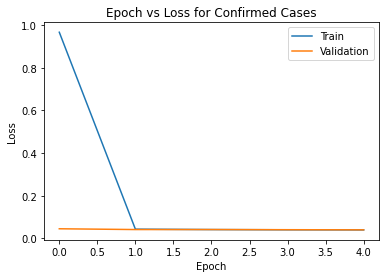

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Epoch vs Loss for Confirmed Cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [0]:
# Save the model
model_c.save(save_path + 'confirmed_lstm.h5')

# Routines for Forecasting

In [0]:
covid_timeseries = df.groupby(['date','country'])['confirmed', 'deaths'].sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [0]:
covid_timeseries=covid_timeseries.reset_index().sort_values('date')

In [0]:
covid_timeseries[covid_timeseries['country'] =='Canada']

,date,country,confirmed,deaths
32,2020-01-22,Canada,0,0
217,2020-01-23,Canada,0,0
402,2020-01-24,Canada,0,0
587,2020-01-25,Canada,0,0
772,2020-01-26,Canada,1,0
...,...,...,...,...
15017,2020-04-12,Canada,24298,714
15202,2020-04-13,Canada,25679,779
15387,2020-04-14,Canada,27034,899
15572,2020-04-15,Canada,28208,1006


In [0]:
# Utility method for Forcasting
# model - trained model on Confirmed/Deaths data
# start_date - Starting date of forcasting
# num_days - Number of days for which forcasting is required
def forecast(model,data,start_date,num_days,win_size=7):
  """
	Makes a forecast based on model
	Arguments:
    model: Model trained on data
		data: The test data
    num_days: Number of days to forecast
		win_size: Window size for forecasting
	Returns:
		Dataframe with the prediction for each country

    SOURCE: Kaggle
	"""
  result_=dict()
  for i in range(len(data)):
      result_[i]=[]
  y_pred=model.predict(data)
  dates=[]
  date_temp = pd.datetime.strptime(start_date, "%Y-%m-%d")
  for j in range(1,num_days+1):
      for i in range(len(data)): # This loops for each country
          cur_window=list(data[i][0][1:win_size+1])
          result_[i].append(cur_window[-1])
          cur_window.append(y_pred[i])
          data[i][0]=cur_window
      y_pred=model.predict(data)
      dates.append(date_temp.strftime("%Y-%m-%d"))
      date_temp+=relativedelta(days=1)
  result=pd.DataFrame(pd.DataFrame(pd.DataFrame(result_).values.T)) 
  result.columns=dates
  result['country']=countries
  return result

In [0]:
forecast_start_date=forecast_date
r = forecast(model_c, X_test_c, forecast_start_date, 5, win_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  import sys


In [0]:
r.head()

,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,country
0,784,835,892,951,1012,Afghanistan
1,494,499,506,510,514,Albania
2,2160,2191,2220,2261,2276,Algeria
3,673,678,680,686,688,Andorra
4,19,18,17,17,16,Angola


In [0]:
r[r['country'] == 'Canada']

,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,country
28,28208,29065,29937,30725,31465,Canada


In [0]:
canada_series = covid_timeseries[covid_timeseries['country'] == 'Canada']
canada_predict = r[r['country'] == 'Canada'].drop(columns='country').T

In [0]:
canada_predict

,28
2020-04-14,28208
2020-04-15,29065
2020-04-16,29937
2020-04-17,30725
2020-04-18,31465


In [0]:
def predict_extract_country(pred, metric_name, country):

  temp = pred[pred['country'] == country]

  # Drops the 'country' column and transpose it into long form
  temp = temp.drop(columns='country').T

  # Convert index into datetime
  temp.index = pd.to_datetime(temp.index)
  # Rename column to 'metric_name_forecast'
  heading = metric_name + '_forecast'
  temp.columns = [heading]
  return temp


# Test on Canada

In [0]:
canada_predict = predict_extract_country(r, 'confirmed', 'Canada')

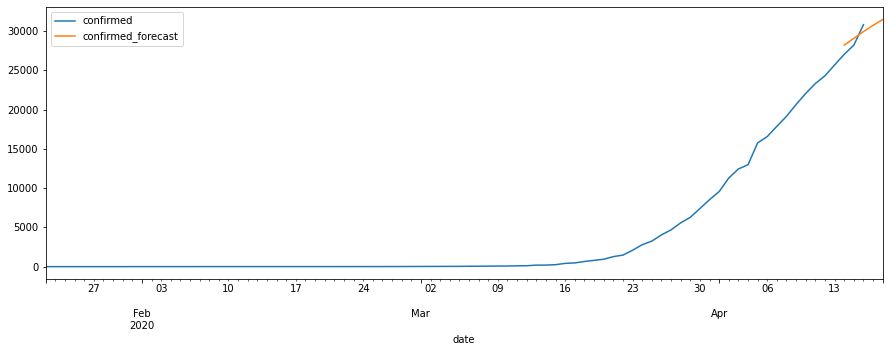

In [0]:
ax = canada_series.plot(x='date', y='confirmed', figsize=(15,5))
canada_predict.plot(ax=ax)

# For any country

In [0]:
country = 'Italy'
true = covid_timeseries[covid_timeseries['country'] == country]
predict = predict_extract_country(r, 'confirmed', country)

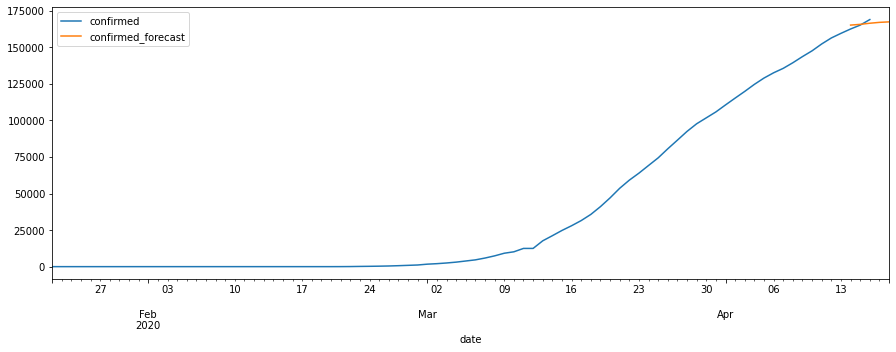

In [0]:
ax = true.plot(x='date', y='confirmed', figsize=(15,5))
predict.plot(ax=ax)